## Modelling and Prediction

* In this notebook, the model selection process along with the assessment of models is carried out.
* Stacking using GradientBoostingClassifier is carried out.

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import sys
import time
import warnings

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

from scipy import stats

from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from my_utils import *

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
train = pd.read_csv("processed_data/train_processed.csv", index_col=0)
test = pd.read_csv("processed_data/test_processed.csv", index_col=0)

In [3]:
data = pd.concat([train, test])

In [4]:
train['Claim'].value_counts()

0.0    49812
1.0      741
Name: Claim, dtype: int64

In [5]:
len(train.columns)

153

* The data is highly imbalanced. Also, the number of features is high.
* Using all features may introduce noise during training. Sampling options and PCA will be explored.
* In order to know the right number of principal components to choose for PCA, a Scree plot and percentage of variance explained wrt features is plotted.

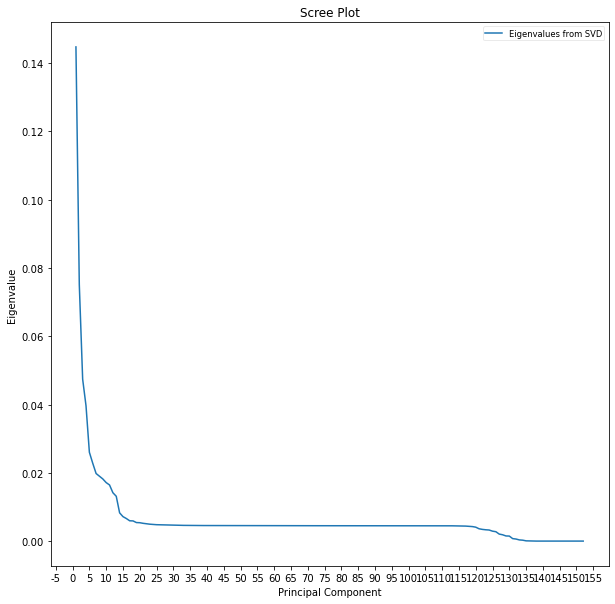

In [6]:
scree_test(data.drop(columns=['Claim'], axis=1, inplace=False))

* The curve flattens at around 20-25 principal components.

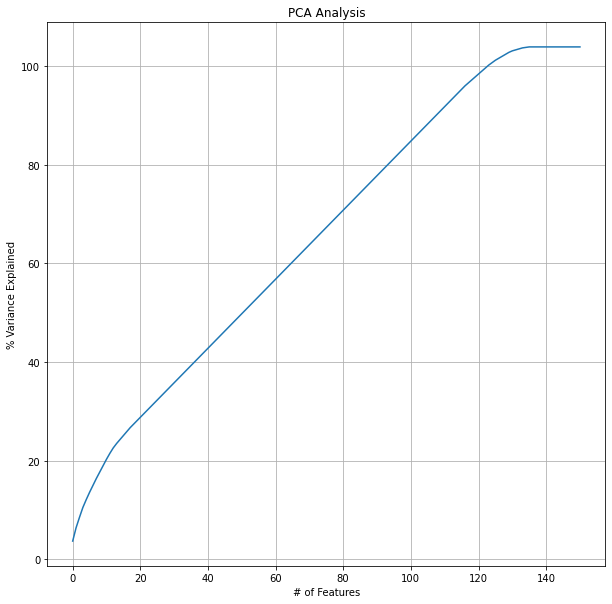

In [7]:
explained_cumvar(data.drop(columns=['Claim'], axis=1, inplace=False))

* 115 features explain about 95% of the variance.

* A significant loss in information may occur if 25 PC are used while 115 PC may defeat the purpose of dimensionality reduction.
* In the first case, the model may underfit with some classifiers and be unable to predict a claim even with oversampling.
* In the second case, the model may take a significantly longer time to train and may lead to high variance and overfitting.

* Proceeding with preparing unmodified, PCA 25 and PCA 115 data.

In [8]:
X, y = train.drop(columns=['Claim', 'ID'], axis=1, inplace=False), train['Claim'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   stratify=y, random_state=42)

In [9]:
pca_25 = PCA(n_components=25, random_state=42)
_ = pca_25.fit(X)

X_train_index = X_train.index
X_train_pca_25 = pca_25.transform(X_train)
X_train_pca_25 = pd.DataFrame(data=X_train_pca_25,
                              index=X_train_index)
X_train_pca_25.rename(columns={i:f'pc_{str(i)}' for i in range(25)}, 
                     inplace=True)

X_test_index = X_test.index
X_test_pca_25 = pca_25.transform(X_test)
X_test_pca_25 = pd.DataFrame(data=X_test_pca_25,
                             index=X_test_index)
X_test_pca_25.rename(columns={i:f'pc_{str(i)}' for i in range(25)}, 
                     inplace=True)

In [10]:
pca_115 = PCA(n_components=115, random_state=42)
_ = pca_115.fit(X)

X_train_index = X_train.index
X_train_pca_115 = pca_115.transform(X_train)
X_train_pca_115 = pd.DataFrame(data=X_train_pca_115,
                               index=X_train_index)
X_train_pca_115.rename(columns={i:f'pc_{str(i)}' for i in range(115)}, 
                     inplace=True)

X_test_index = X_test.index
X_test_pca_115 = pca_115.transform(X_test)
X_test_pca_115 = pd.DataFrame(data=X_test_pca_115,
                              index=X_test_index)
X_test_pca_115.rename(columns={i:f'pc_{str(i)}' for i in range(115)}, 
                     inplace=True)

* PCA has been applied to the training data.
* Testing the performance of different models.

In [11]:
clf_to_use = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier,
             ExtraTreesClassifier, KNeighborsClassifier, SVC, AdaBoostClassifier,
             GradientBoostingClassifier, MLPClassifier, LinearDiscriminantAnalysis,
             XGBClassifier]

clf_dict = {}

for clf in clf_to_use:
    try:
        if clf in [AdaBoostClassifier]:
            clf_dict[ get_clf_name(clf) ] = clf(DecisionTreeClassifier(random_state=42, max_depth=15),
                                                learning_rate=0.01, random_state = 42)
        elif clf in [DecisionTreeClassifier, RandomForestClassifier]:
            clf_dict[ get_clf_name(clf) ] = clf(max_depth=15, random_state = 42)
        else:
            clf_dict[ get_clf_name(clf) ] = clf(random_state = 42)
    except:
        # k neighbors
        clf_dict[ get_clf_name(clf) ] = clf()

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.0s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.7s finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.7s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.0s finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.4s finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.6s finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


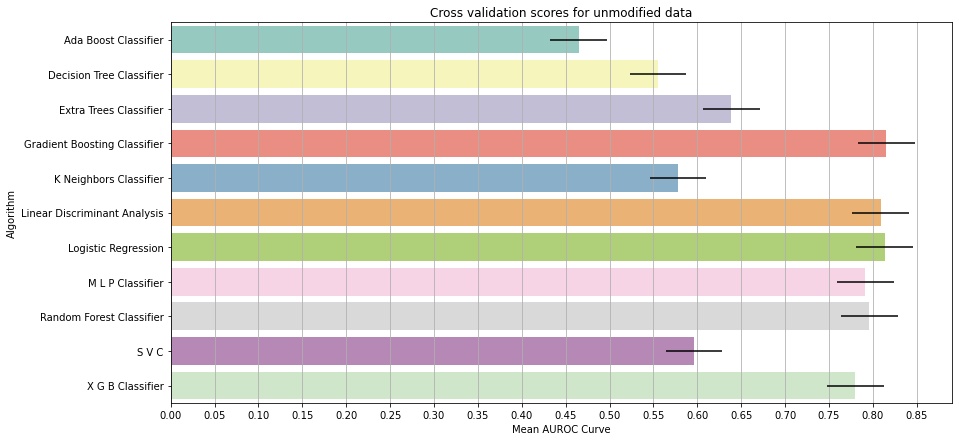

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   45.5s finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.8s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.6s finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.2min finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.7s finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   41.9s finished


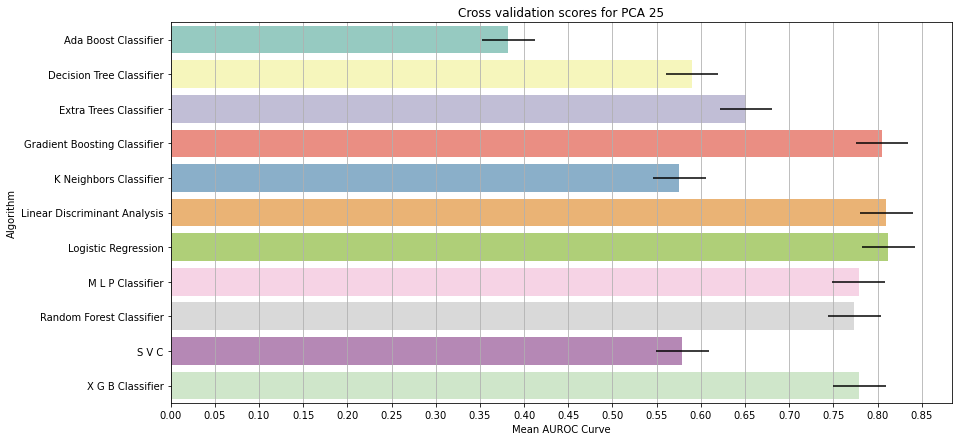

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.8s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.6min finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.3s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.6s finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 14.6min finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.9min finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.4s finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished


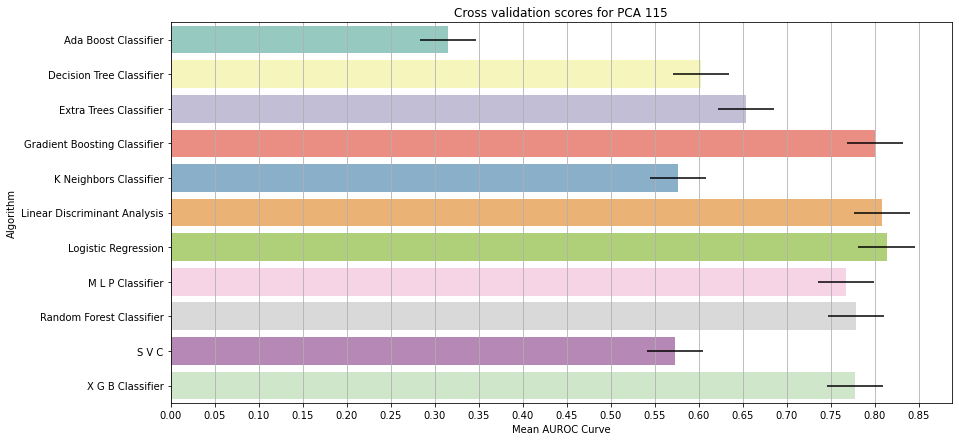

In [13]:
for X_train_, data_kind in zip([X_train, X_train_pca_25, X_train_pca_115], 
                               ['unmodified data', 'PCA 25', 'PCA 115']):
    
    get_all_cv(X_train_.copy(), y_train.copy(), data_kind, 
               clf_dict.copy() )

* Boosting algorithms, logistic regression, perceptron and LDA performed well on the unmodified data.

* The overall performance across classifiers has slightly increased when using PCA 25.

* In this problem, not just the classes are imbalanced but observations for particular features are also imbalanced.
* When undersampled, although the training would be much faster, loss of data and consequently decrease in prediction confidence may occur.
* When oversampled, the training time will be significantly slower but it may help reduce assignment of weights to bigger classes which would have otherwise skewed the prediction by increasing accuracy while plummeting recall.

# Undersampling

In [12]:
df = X_train.copy()
df['target'] = y_train.copy()

positive_class = df[ df['target']==1 ]
negative_class = df[ df['target']==0 ].sample(n=len(positive_class), 
                                              random_state=42, )

undersampled_df = pd.concat([negative_class, positive_class])

X_train_under, y_train_under = undersampled_df.drop('target', axis=1,), undersampled_df['target'].copy()

X_train_pca_25_under = X_train_pca_25[ X_train_pca_25.index.isin(X_train_under.index) ].copy()
X_train_pca_115_under = X_train_pca_115[ X_train_pca_115.index.isin(X_train_under.index) ].copy()

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


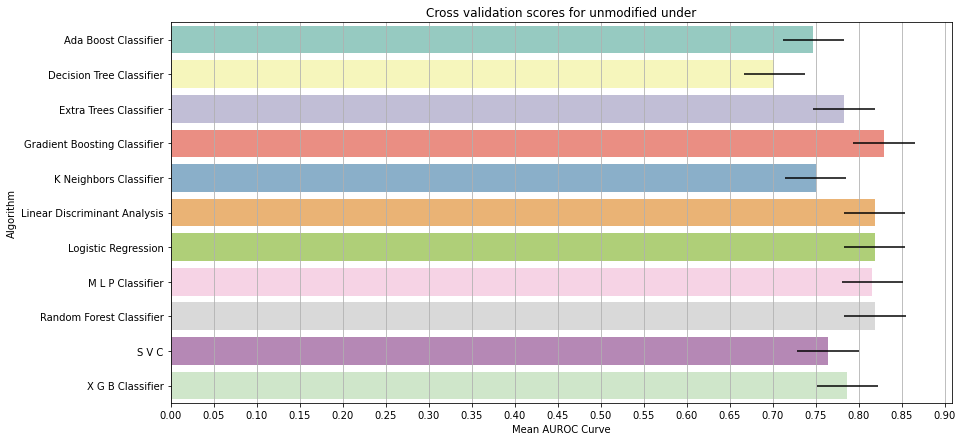

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


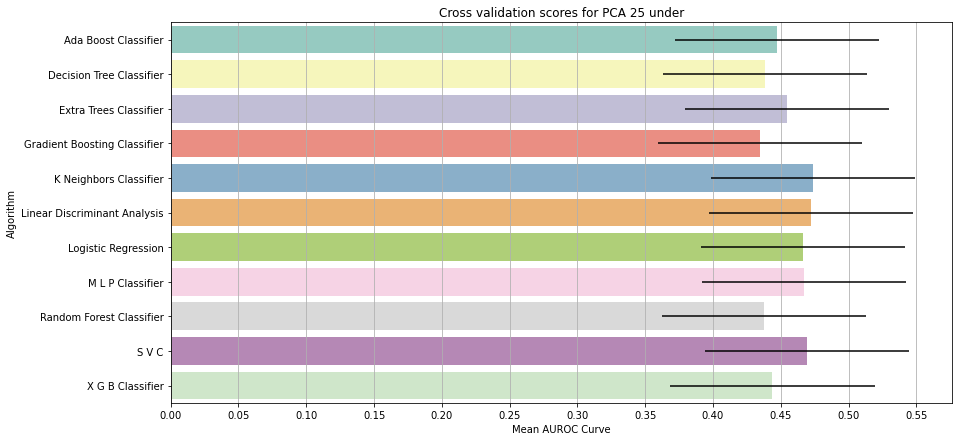

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.1s finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.8s finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.3s finished


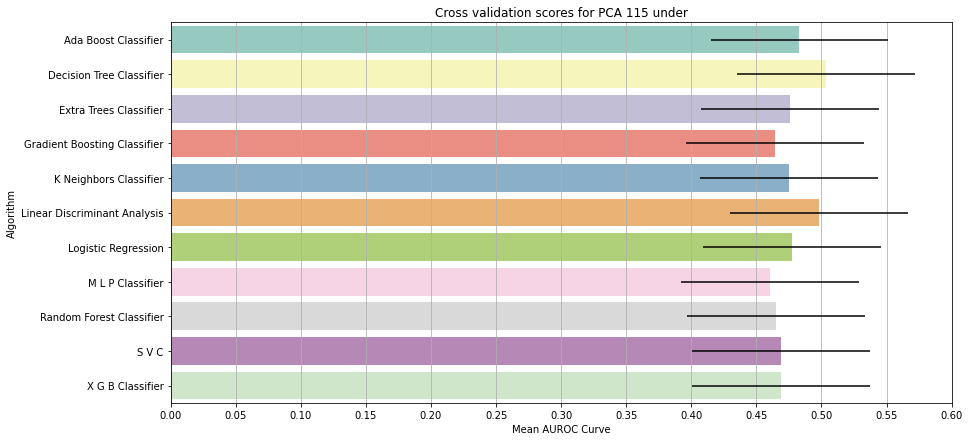

In [15]:
for X_train_, data_kind in zip([X_train_under, X_train_pca_25_under, X_train_pca_115_under], 
                               ['unmodified under', 'PCA 25 under', 'PCA 115 under']):
    
    get_all_cv(X_train_.copy(), y_train_under.copy(), data_kind, 
               clf_dict.copy() )

# Oversampling

In [13]:
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)

X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

X_train_pca_25_over, y_train_pca_25_over = oversampler.fit_resample(X_train_pca_25, y_train)

X_train_pca_115_over, y_train_pca_115_over = oversampler.fit_resample(X_train_pca_115, y_train)

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.5s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.3s finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   48.9s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.6s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 43.5min finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   60.0s finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.1min finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.6s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished


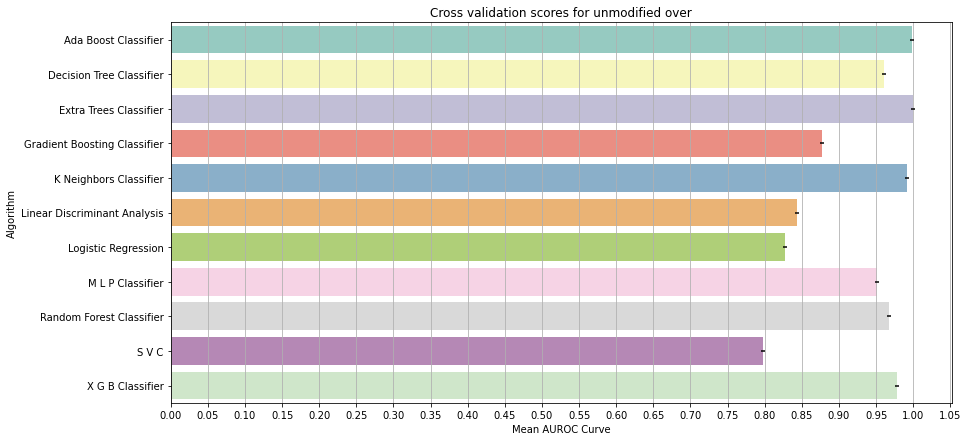

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   51.1s finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.0s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.3min finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.6min finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


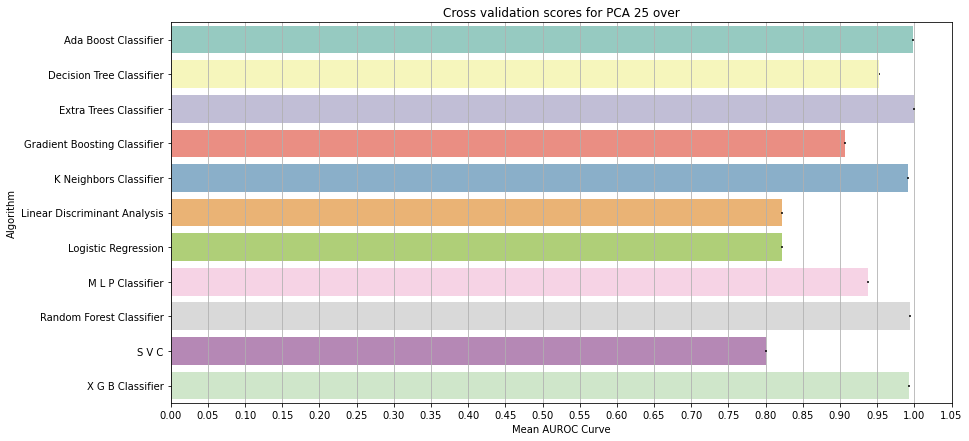

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.6s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.6min finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   54.5s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.1s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 33.8min finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 16.3min finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.7min finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.9min finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.5s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.8min finished


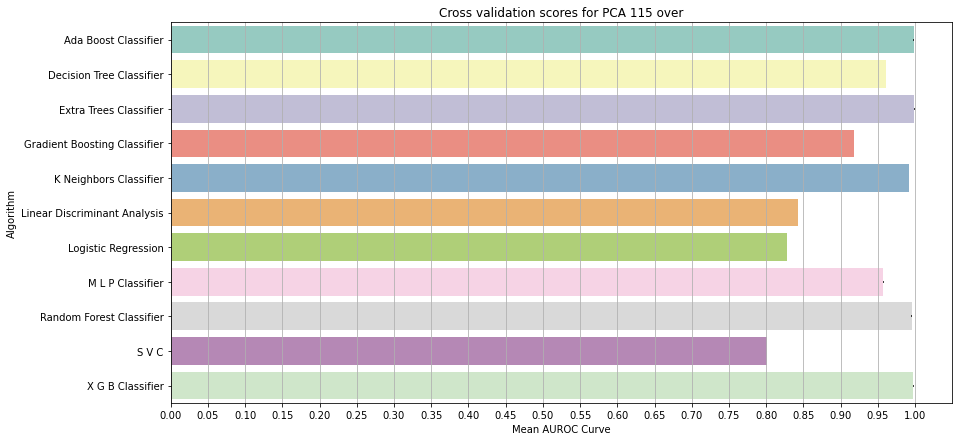

In [17]:
for X_train_, data_kind, y_train_ in zip([X_train_over, X_train_pca_25_over, X_train_pca_115_over],
                                         ['unmodified over', 'PCA 25 over', 'PCA 115 over'],
                                         [y_train_over, y_train_pca_25_over, y_train_pca_115_over]):
    
    get_all_cv(X_train_.copy(), y_train_.copy(), data_kind, 
               clf_dict.copy() )

# SMOTE

In [14]:
smote = SMOTE(sampling_strategy='not majority', random_state=4)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train_pca_25_smote, y_train_pca_25_smote = smote.fit_resample(X_train_pca_25, y_train)

X_train_pca_115_smote, y_train_pca_115_smote = smote.fit_resample(X_train_pca_115, y_train)

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.8s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.5s finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   44.3s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.6s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 44.1min finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.1min finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.7s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished


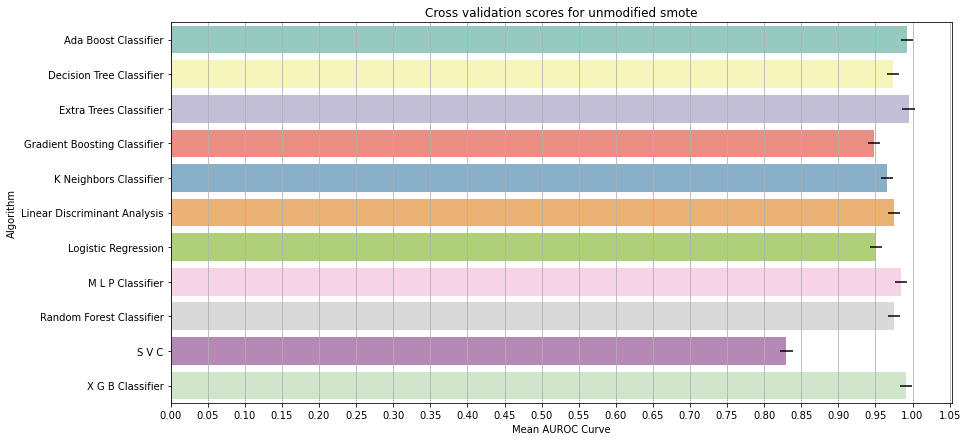

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   26.6s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.2min finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.0min finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.9min finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.2min finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


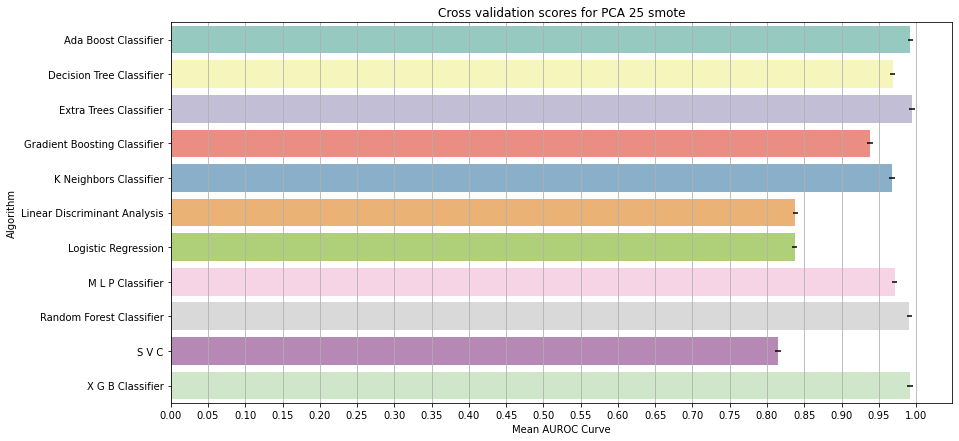

Fitting Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished


Fitting Decision Tree Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.8s finished


Fitting Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.9min finished


Fitting Extra Trees Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   58.3s finished


Fitting K Neighbors Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.9s finished


Fitting S V C


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 33.7min finished


Fitting Ada Boost Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 27.9min finished


Fitting Gradient Boosting Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.6min finished


Fitting M L P Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.0min finished


Fitting Linear Discriminant Analysis


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished


Fitting X G B Classifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.3min finished


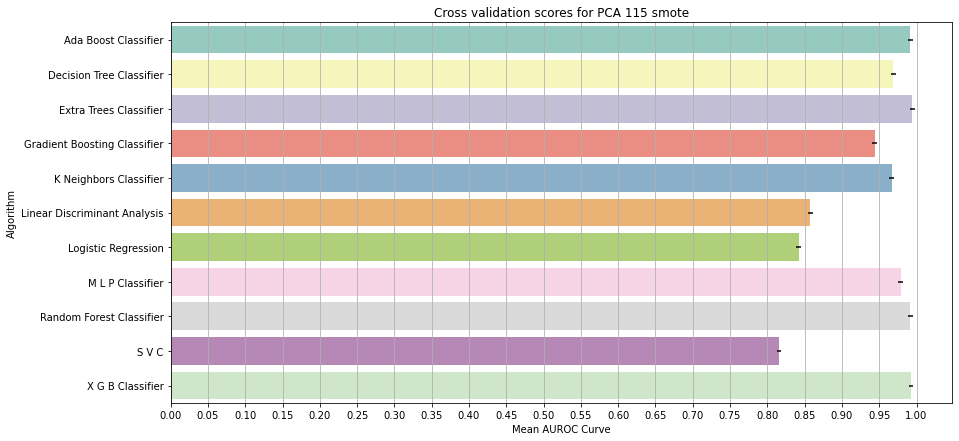

In [19]:
for X_train_, data_kind, y_train_ in zip([X_train_smote, X_train_pca_25_smote, X_train_pca_115_smote],
                                         ['unmodified smote', 'PCA 25 smote', 'PCA 115 smote'],
                                         [y_train_smote, y_train_pca_25_smote, y_train_pca_115_smote]):
    
    get_all_cv(X_train_.copy(), y_train_.copy(), data_kind, 
               clf_dict.copy() )

#### Observations
* Unsampled data
    * Performance across unmodified, PCA 25 and PCA 115 remained relatively the same.
    * LDA, KNN and Extra Trees performed well.
<br><br>    
* Undersampling
    * In case of undersampling, performance for unmodified data increased significantly across all models. On the other hand, PCA 25 and PCA 115 data became useless due to very high amounts of error.
    * RF, MLP, LogReg, GradientBoosting performed well.
<br><br> 
* Oversampling
    * Errors in prediction across CV folds reduced drastically for all. While LDA, LogReg and SVC had just acceptable performance, all other classifiers performed excellently.
    * Performance: PCA 115 > PCA 25 > Unmodified.
    * But this may be a case of severe overfitting.
<br><br>
* SMOTE
    * For unmodified data, performance across all classifiers (except SVC) was outstanding with some error in each case.
    * For PCA 25 and PCA 115, performance was more or less the same as in case of oversampling.
    * But this may be a case of severe overfitting.

* Before selecting the models and data for ensemble, let's verify if there was overfitting in cases of Oversampling and SMOTE or not.

## AUROCC against test data

In [15]:
y_test.value_counts()

0.0    14944
1.0      222
Name: Claim, dtype: int64

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1000, p=2,
                     weights='uniform')

0.0    11115
1.0     4051
dtype: int64

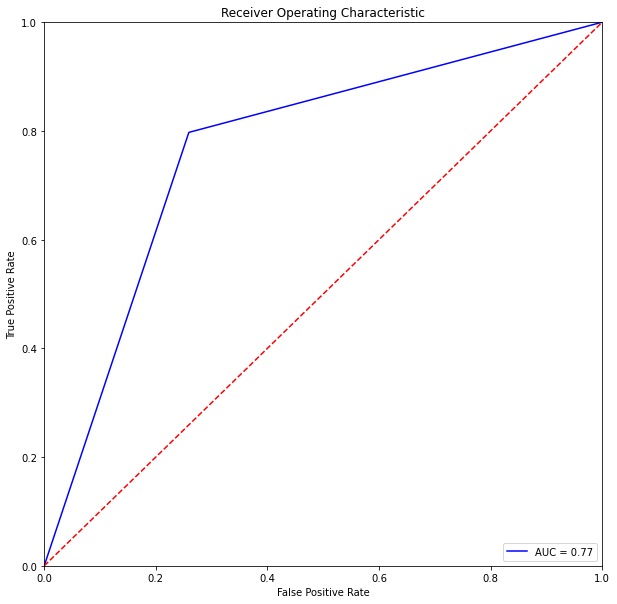

In [16]:
model = KNeighborsClassifier(n_neighbors=1000)
model.fit(X_train_pca_25_over, y_train_pca_25_over)
y_pred = model.predict(X_test_pca_25)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=4, splitter='best')

0.0    13232
1.0     1934
dtype: int64

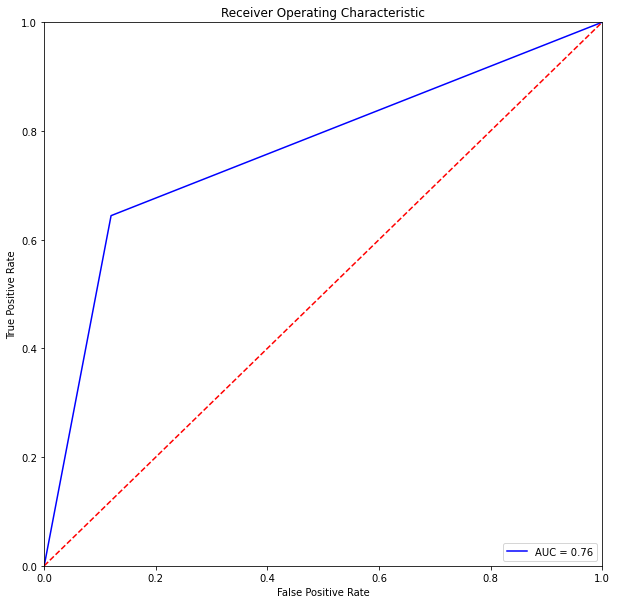

In [46]:
model = DecisionTreeClassifier(random_state=4, max_depth=4)
model.fit(X_train_pca_25_over, y_train_pca_25_over)
y_pred = model.predict(X_test_pca_25)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

0.0    12915
1.0     2251
dtype: int64

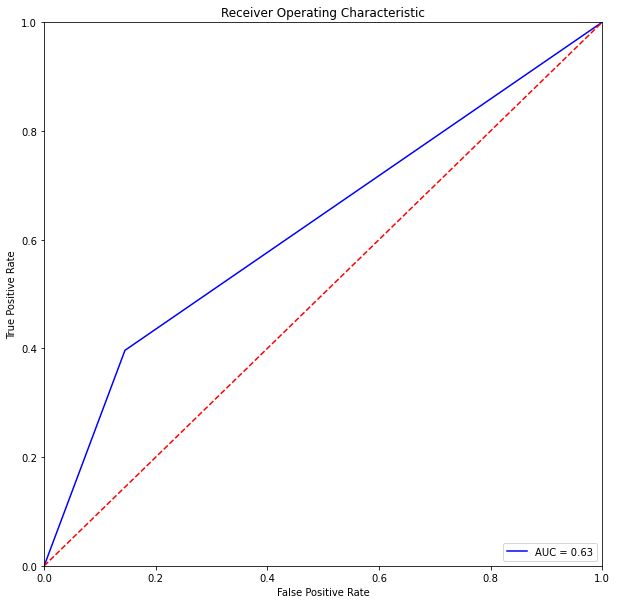

In [66]:
model = KNeighborsClassifier()
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

0.0    13288
1.0     1878
dtype: int64

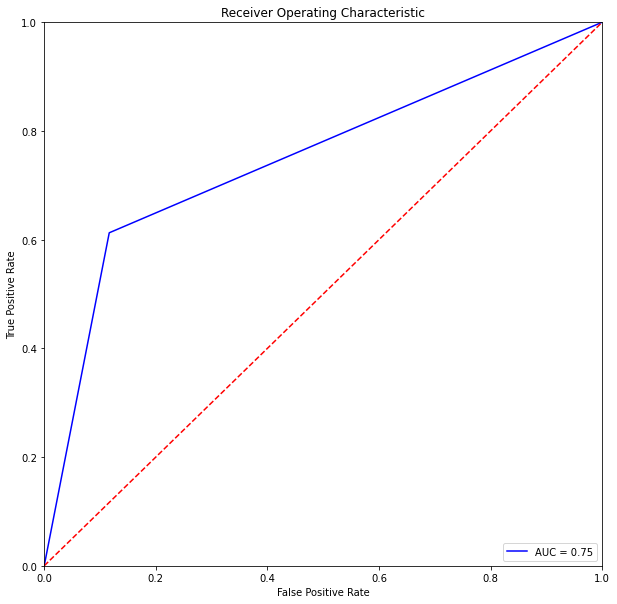

In [65]:
model = DecisionTreeClassifier(random_state=42, max_depth=4)
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

* It looks like the model is overfitting in cases of both oversampling and SMOTE because the training AUROCC is around 0.95 while during testing it drops to around 0.70 - 0.75.
* Let's see how the performance is in case of unsampled and undersampled data.

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

0.0    11863
1.0     3303
dtype: int64

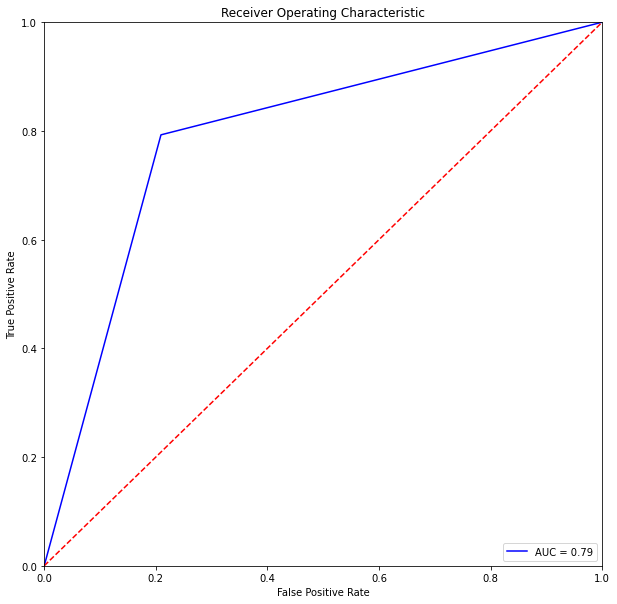

In [25]:
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

LinearDiscriminantAnalysis(n_components=25, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

0.0    14745
1.0      421
dtype: int64

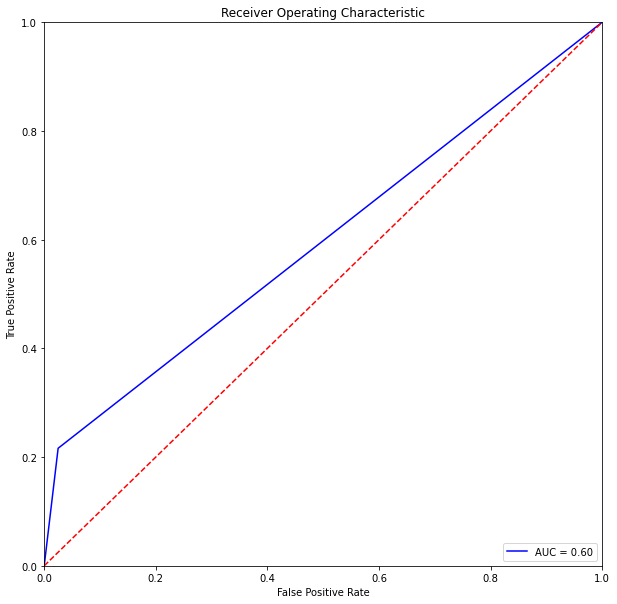

In [79]:
model = LinearDiscriminantAnalysis(n_components=25, )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

0.0    12240
1.0     2926
dtype: int64

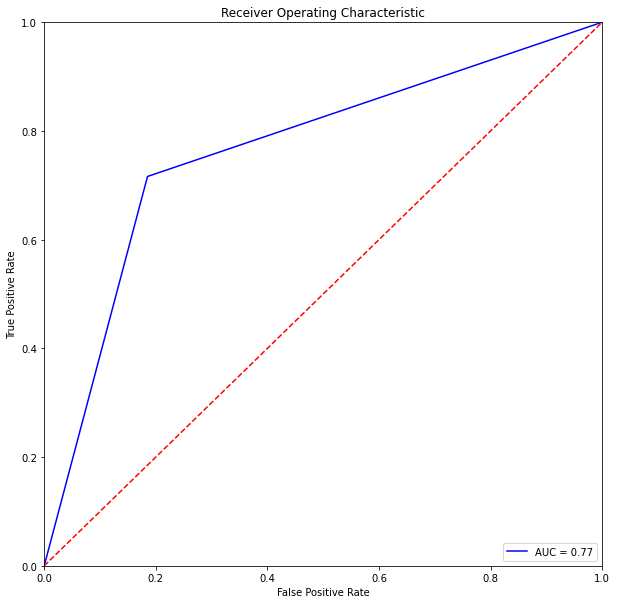

In [44]:
model = GradientBoostingClassifier(random_state=42)

sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 1
sample_weights[y_train == 1] = 34868/519

model.fit(X_train, y_train, sample_weights)
y_pred = model.predict(X_test)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

* The performance is good with unsampled data.
* Let's look at the how undersampling performed.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

0.0    11689
1.0     3477
dtype: int64

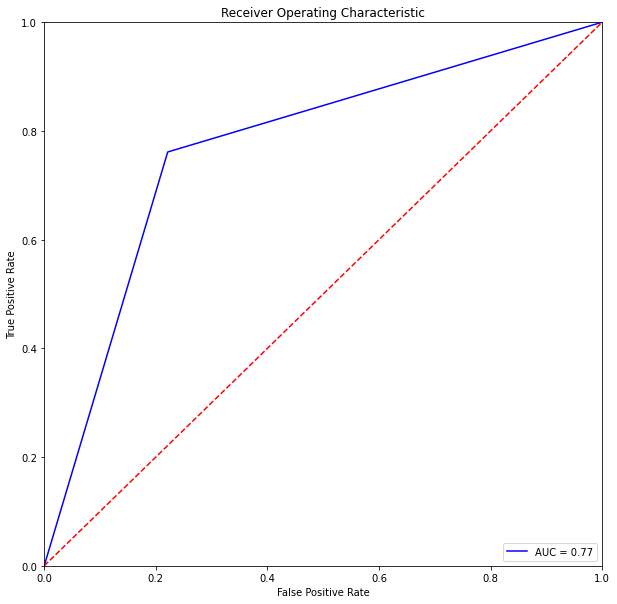

In [75]:
model = LogisticRegression(random_state=42, )
model.fit(X_train_under, y_train_under)
y_pred = model.predict(X_test)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

LinearDiscriminantAnalysis(n_components=25, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

0.0    11736
1.0     3430
dtype: int64

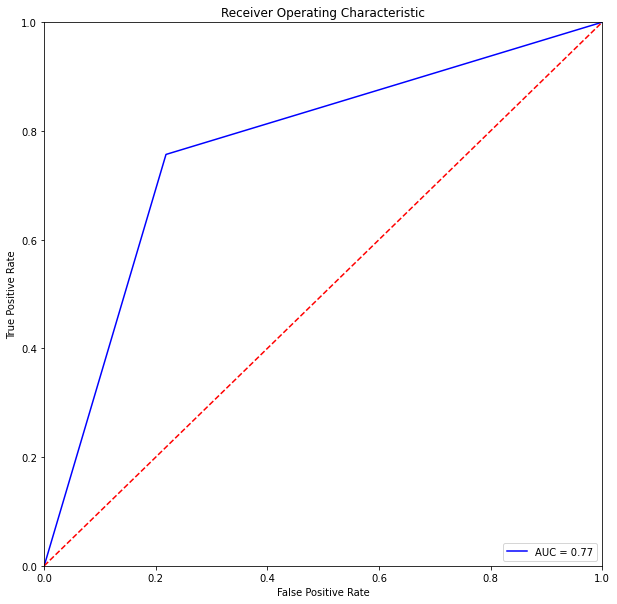

In [76]:
model = LinearDiscriminantAnalysis(n_components=25)
model.fit(X_train_under, y_train_under)
y_pred = model.predict(X_test)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

0.0    11383
1.0     3783
dtype: int64

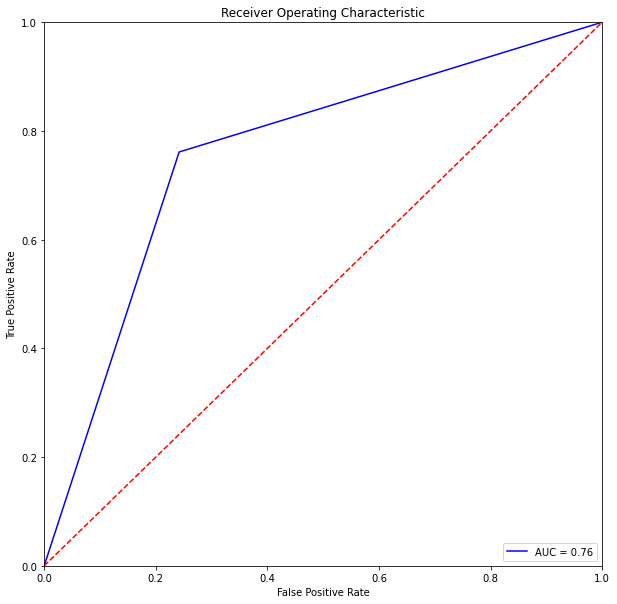

In [77]:
model = GradientBoostingClassifier(random_state=42, )
model.fit(X_train_under, y_train_under)
y_pred = model.predict(X_test)

pd.Series(y_pred).value_counts()
plot_auc(y_test, y_pred)

* Performance with undersampling was good and it took much lesser training time.
* It looks like in case of undersampling, the model performance for training and testing has converged. As a result, the training and testing performance is comparable.

* Lastly, let's check for convergence in oversampled and smote data. Unmodified and PCA 25 data will be used. Classifiers used will be DT, KNN, LDA, LogReg.
* This will help verify overfitting and aid in taking next steps.

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    2.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

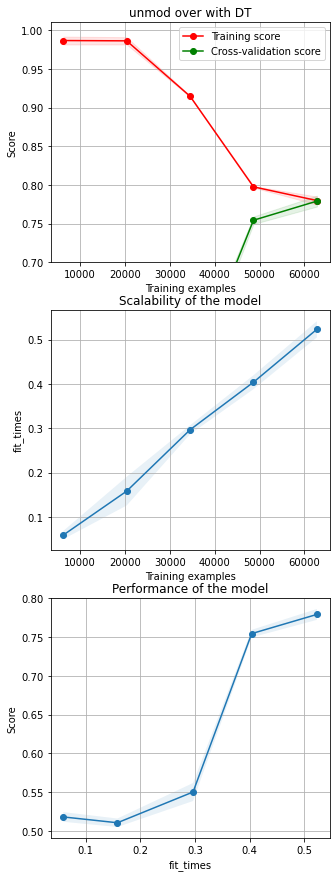

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

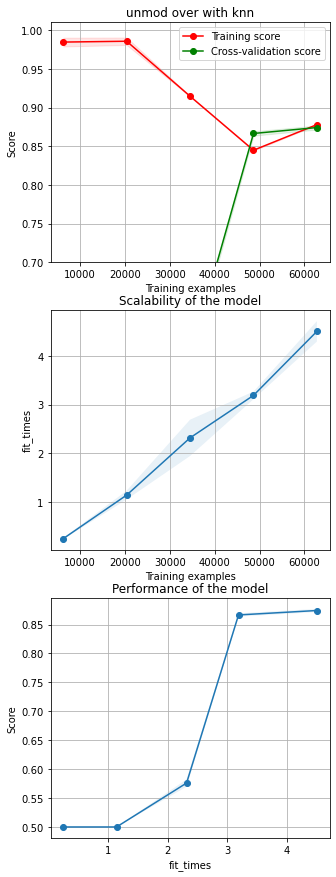

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    8.1s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.8s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

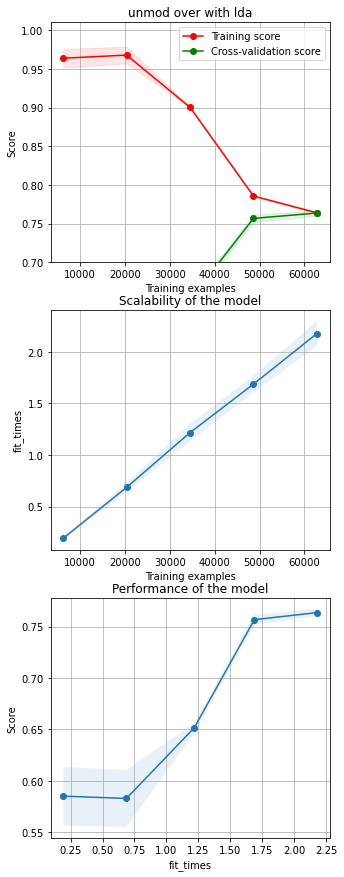

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   11.5s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.6s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

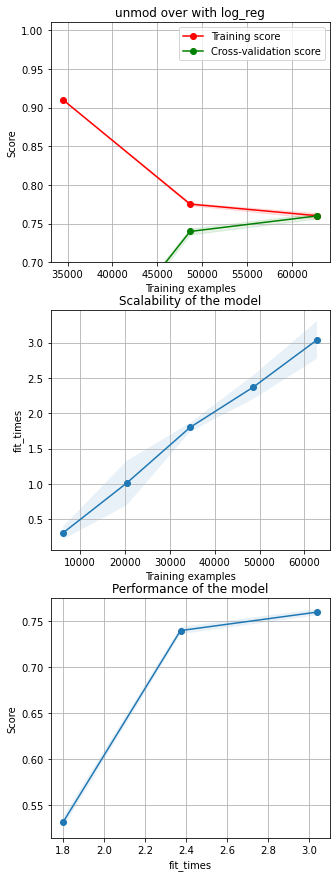

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    2.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

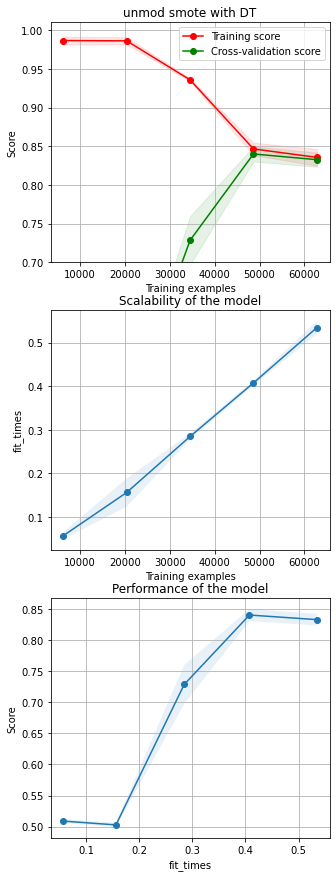

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

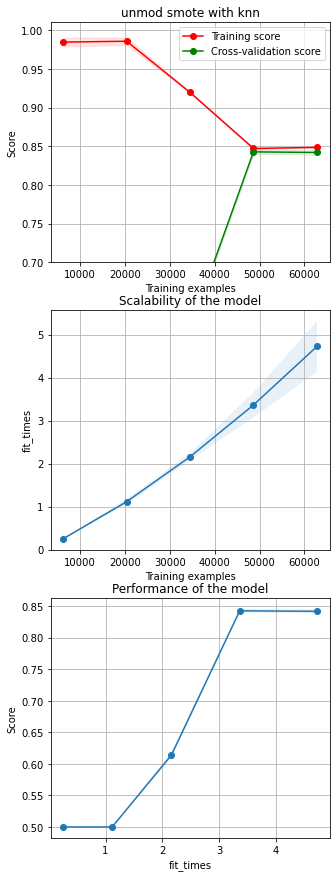

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.7s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

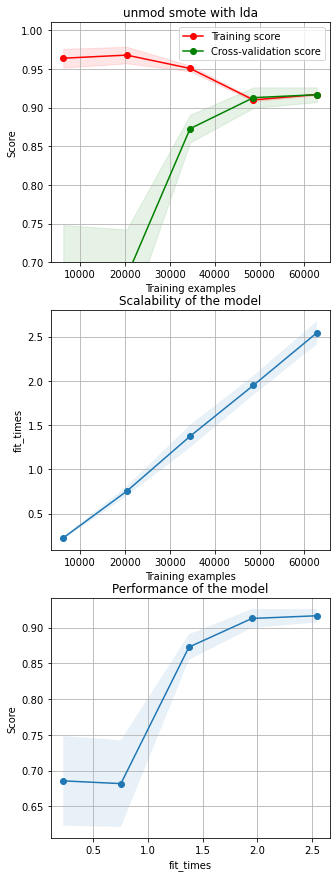

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   13.8s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.0s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

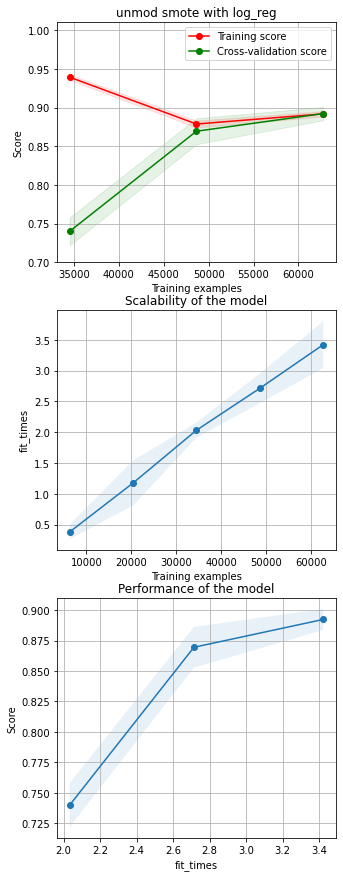

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    4.7s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

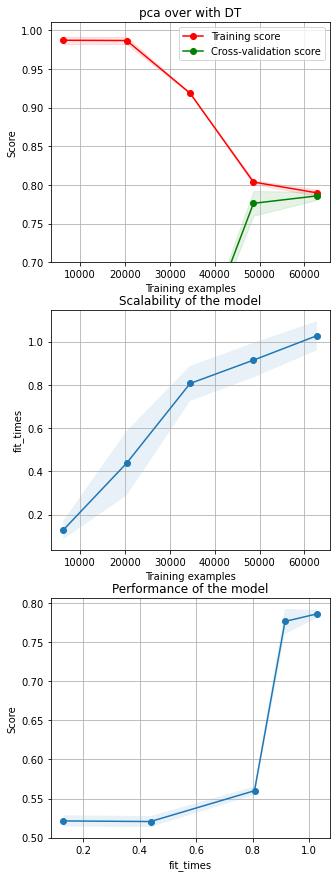

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   34.3s remaining:   34.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

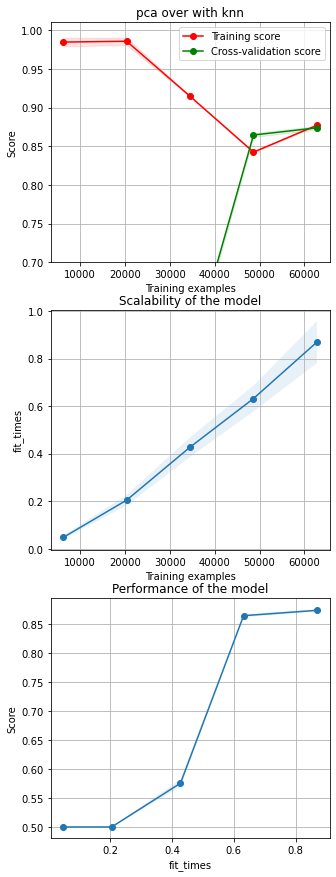

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

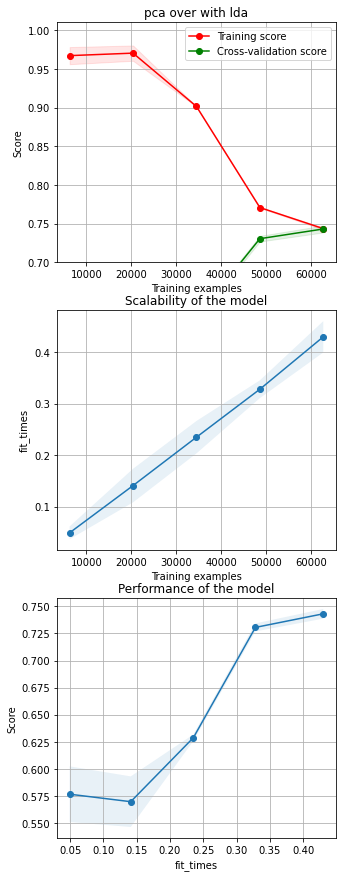

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    4.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.4s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

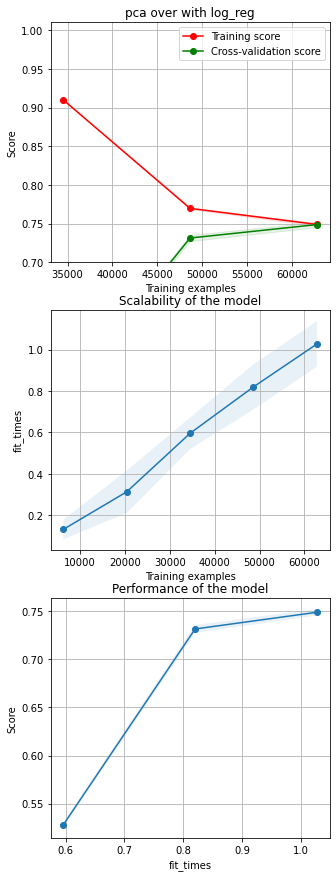

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.0s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

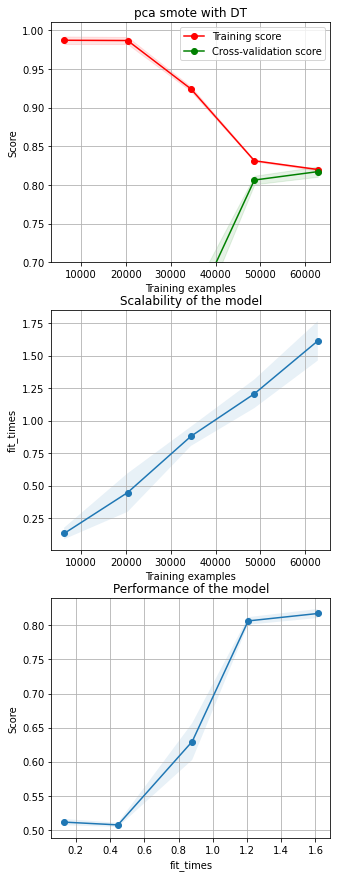

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   31.0s remaining:   31.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

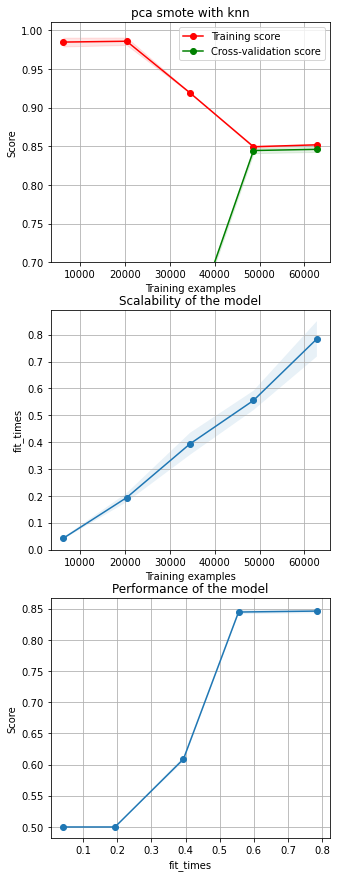

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

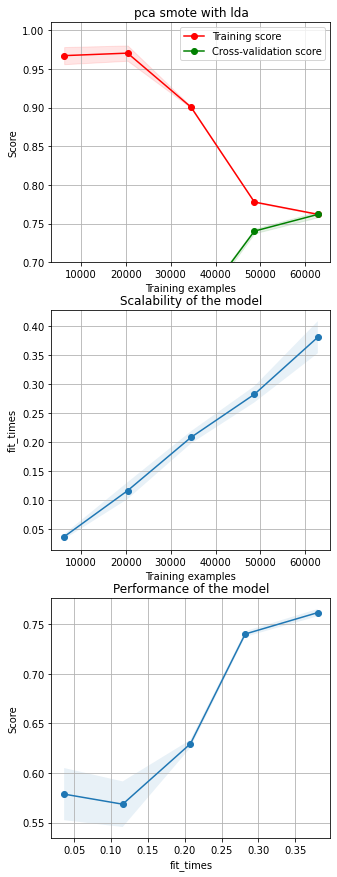

[learning_curve] Training set sizes: [ 6276 20397 34519 48640 62762]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    4.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.1s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

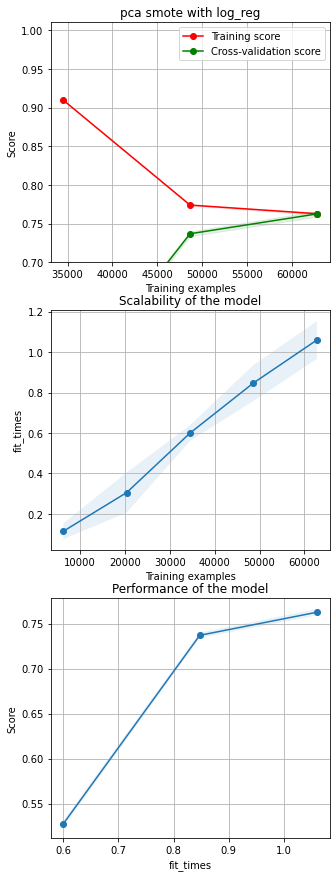

In [88]:
for X_train__, y_train__, X_test__, title_a in [[X_train_over, y_train_over, X_test, 'unmod over'],
                                          [X_train_smote, y_train_smote, X_test, 'unmod smote'],
                                          [X_train_pca_25_over, y_train_pca_25_over, X_test_pca_25, 'pca over'],
                                          [X_train_pca_25_smote, y_train_pca_25_smote, X_test_pca_25, 'pca smote']]:
    for model, title_b in [[DecisionTreeClassifier(random_state=42, max_depth=6), 'DT'], 
              [KNeighborsClassifier(n_neighbors=50), 'knn'], 
              [LinearDiscriminantAnalysis(), 'lda'], 
              [LogisticRegression(random_state=42), 'log_reg']]:

        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))

        title = f'{title_a} with {title_b}'

        plot_learning_curve_new(model, title, 
                                X_train__, y_train__, 
                                axes=axes,
                                ylim=(0.7, 1.01),
                                cv=10, n_jobs=-1)

        plt.show()

[learning_curve] Training set sizes: [ 93 303 513 723 934]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.3s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

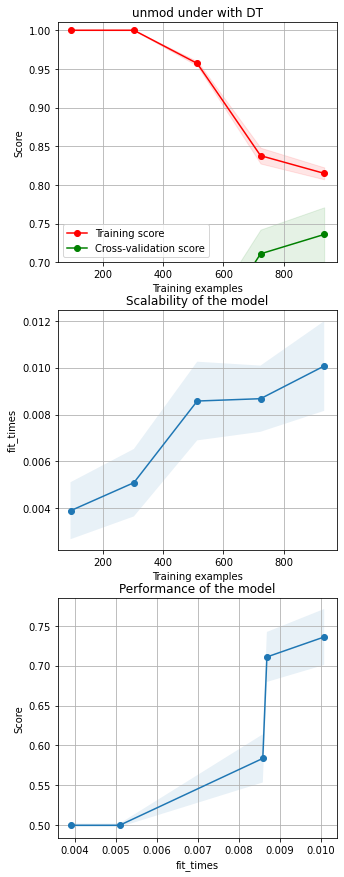

[learning_curve] Training set sizes: [ 93 303 513 723 934]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

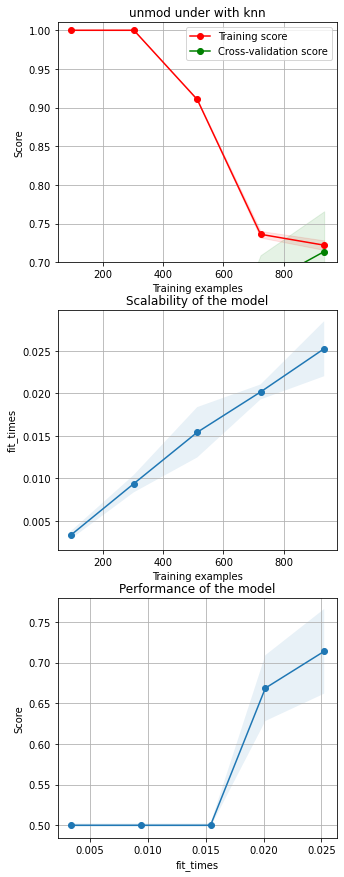

[learning_curve] Training set sizes: [ 93 303 513 723 934]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

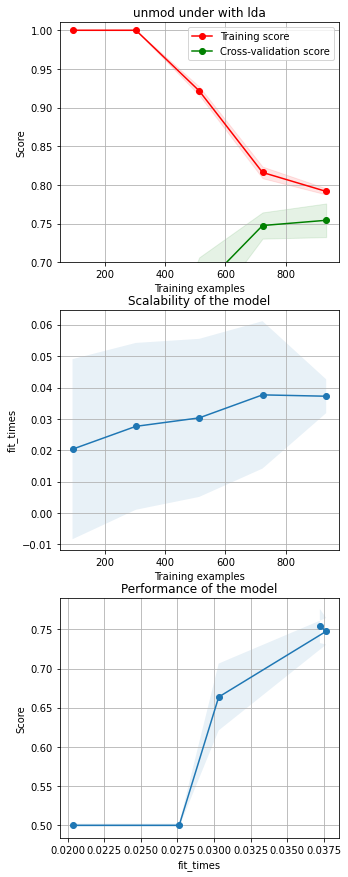

[learning_curve] Training set sizes: [ 93 303 513 723 934]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


<module 'matplotlib.pyplot' from 'C:\\MainStuff\\CodeStuff\\Anaconda3\\envs\\ML\\lib\\site-packages\\matplotlib\\pyplot.py'>

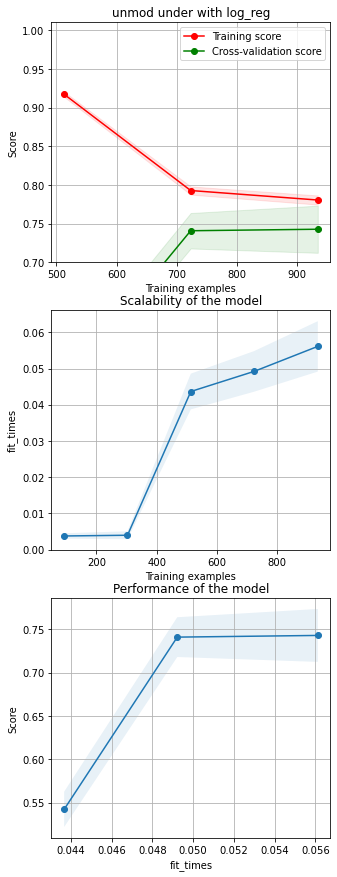

In [89]:
for X_train__, y_train__, X_test__, title_a in [[X_train_under, y_train_under, X_test, 'unmod under']]:
    for model, title_b in [[DecisionTreeClassifier(random_state=42, max_depth=6), 'DT'], 
              [KNeighborsClassifier(n_neighbors=50), 'knn'], 
              [LinearDiscriminantAnalysis(), 'lda'], 
              [LogisticRegression(random_state=42), 'log_reg']]:

        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))

        title = f'{title_a} with {title_b}'

        plot_learning_curve_new(model, title, 
                                X_train__, y_train__, 
                                axes=axes,
                                ylim=(0.7, 1.01),
                                cv=10, n_jobs=-1)

        plt.show()

* The models fit too much to the training data and hence failed to generalize on unseen data.
* It's observed that undersampling leads to a good fit and takes less time.
* A combination of tree based models (to understand the feature importance), boosting models (to better predict the rarer values) and regularized models will be used.

In [17]:
trained_models = {}

# AdaBoost

In [18]:
X_train__, y_train__ = X_train_under.copy(), y_train_under.copy()

Found trained model file with same name. Loading it instead.


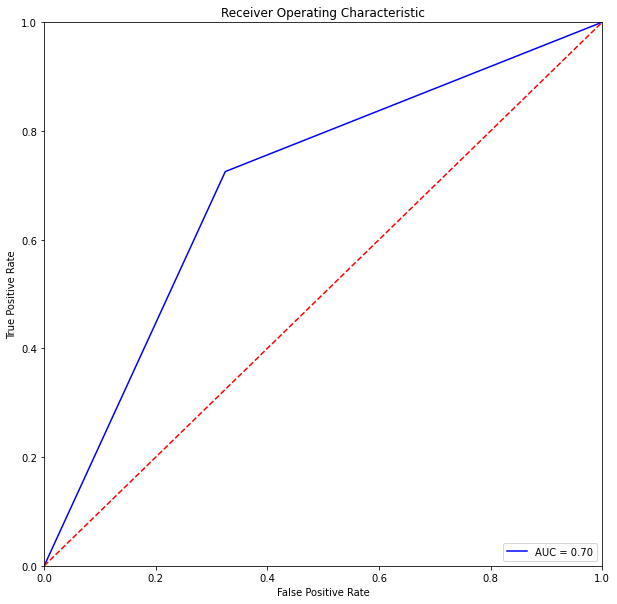

In [19]:
scoring_ = "roc_auc"

file_name = "trained models/adaboost_5.pickle"

model = AdaBoostClassifier( DecisionTreeClassifier(random_state=42,
                                                  max_depth=4,
                                                  max_features=25) )

hyperparameters = {'n_estimators': [25, 100, 250, 1000],
                   'learning_rate': [1.0, 0.5],
                  }

gscv_model = GridSearchCV(model, param_grid=hyperparameters, 
                          cv=10, scoring=scoring_, 
                          n_jobs=-1, verbose=1,
                          return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        gscv_model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    gscv_model.fit(X_train__, y_train__)
    with open(file_name, 'wb') as handle:
        pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, gscv_model)

plot_auc(y_test, gscv_model.best_estimator_.predict(X_test))

# XGBoost

In [20]:
X_train__, y_train__ = X_train_under.copy(), y_train_under.copy()

Found trained model file with same name. Loading it instead.


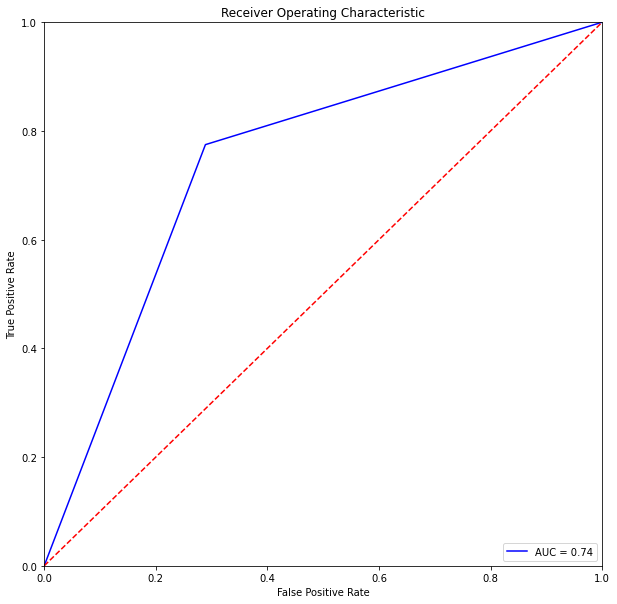

In [21]:
scoring_ = "roc_auc"

file_name = "trained models/xgb_4.pickle"

model = XGBClassifier()

hyperparameters = {'random_state': [42],
                   'max_depth': [4, 8],
                  }

gscv_model = GridSearchCV(model, param_grid=hyperparameters, 
                          cv=10, scoring=scoring_, 
                          n_jobs=-1, verbose=1,
                          return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        gscv_model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    gscv_model.fit(X_train__, y_train__)
    with open(file_name, 'wb') as handle:
        pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, gscv_model)

plot_auc(y_test, gscv_model.best_estimator_.predict(X_test))

# K-Neighbors

In [22]:
X_train__, y_train__ = X_train_under.copy(), y_train_under.copy()

Found trained model file with same name. Loading it instead.


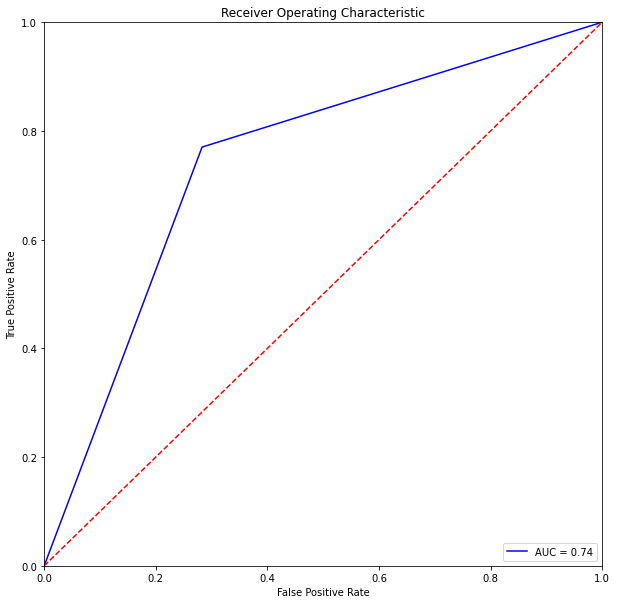

In [23]:
scoring_ = "roc_auc"

file_name = "trained models/knn_4.pickle"

model = KNeighborsClassifier()

hyperparameters = {'weights': ['uniform', 'distance'],
                   'n_jobs': [-1],
                   'leaf_size': [5, 30, 100],
                   
                  }

gscv_model = GridSearchCV(model, param_grid=hyperparameters, 
                          cv=10, scoring=scoring_, 
                          n_jobs=-1, verbose=1,
                          return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        gscv_model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    gscv_model.fit(X_train__, y_train__)
    with open(file_name, 'wb') as handle:
        pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, gscv_model)

plot_auc(y_test, gscv_model.best_estimator_.predict(X_test))

# Random Forest

In [24]:
X_train__, y_train__ = X_train_under.copy(), y_train_under.copy()

Found trained model file with same name. Loading it instead.


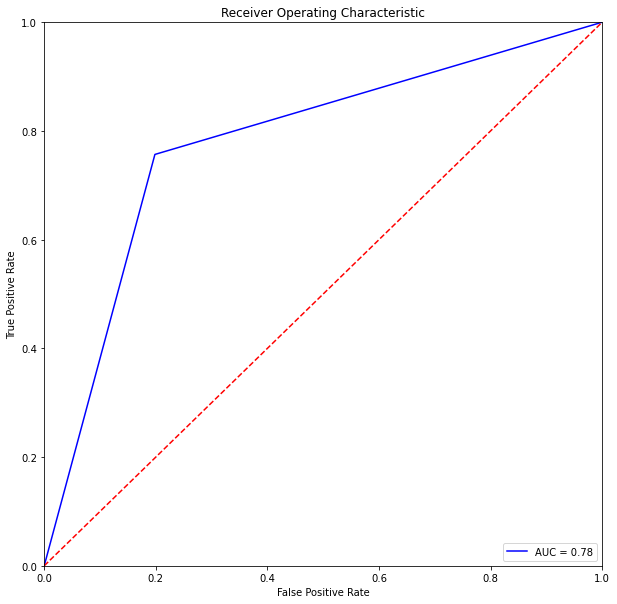

In [25]:
scoring_ = "roc_auc"

file_name = "trained models/random_forest_7.pickle"

model = RandomForestClassifier( random_state = 42,  )

hyperparameters = {"max_depth": [4, 8],
                   "n_estimators": [300, 500],
                   "class_weight": ['balanced', {0: 1, 1: 2}],
                  }

gscv_model = GridSearchCV(model, param_grid=hyperparameters, 
                          cv=10, scoring=scoring_, 
                          n_jobs=2, verbose=1,
                          return_train_score=True)

try:
    with open(file_name, 'rb') as handle:
        gscv_model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    gscv_model.fit(X_train__, y_train__)
    with open(file_name, 'wb') as handle:
        pickle.dump(gscv_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, gscv_model)

plot_auc(y_test, gscv_model.best_estimator_.predict(X_test))

### Ridge Classifier

In [26]:
X_train__, y_train__ = X_train_under.copy(), y_train_under.copy()

Found trained model file with same name. Loading it instead.


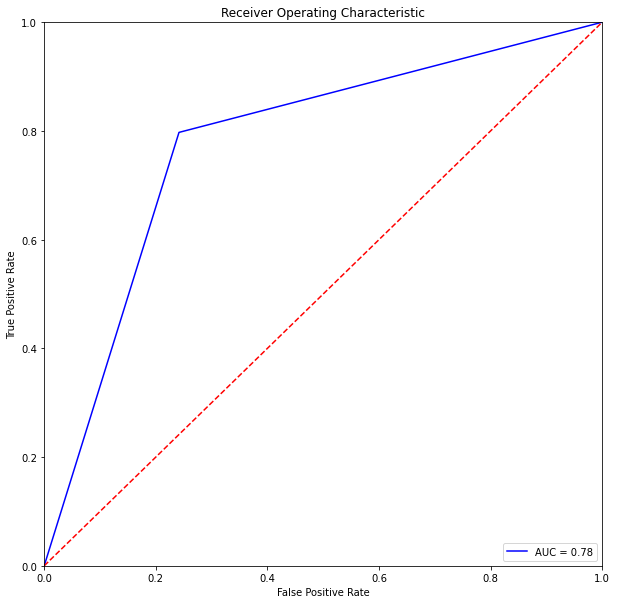

In [27]:
file_name = "trained models/ridge_4.pickle"

model = RidgeClassifier(normalize=True, class_weight={0:1, 1:1.225}, 
                        random_state=42)

try:
    with open(file_name, 'rb') as handle:
        model = pickle.load(handle)
    print("Found trained model file with same name. Loading it instead.")
    
except:
    model.fit(X_train__, y_train__ )
    with open(file_name, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
trained_models[f'{file_name}'] = (scoring_, hyperparameters, model)

plot_auc(y_test, model.predict(X_test))

### Feature Importance

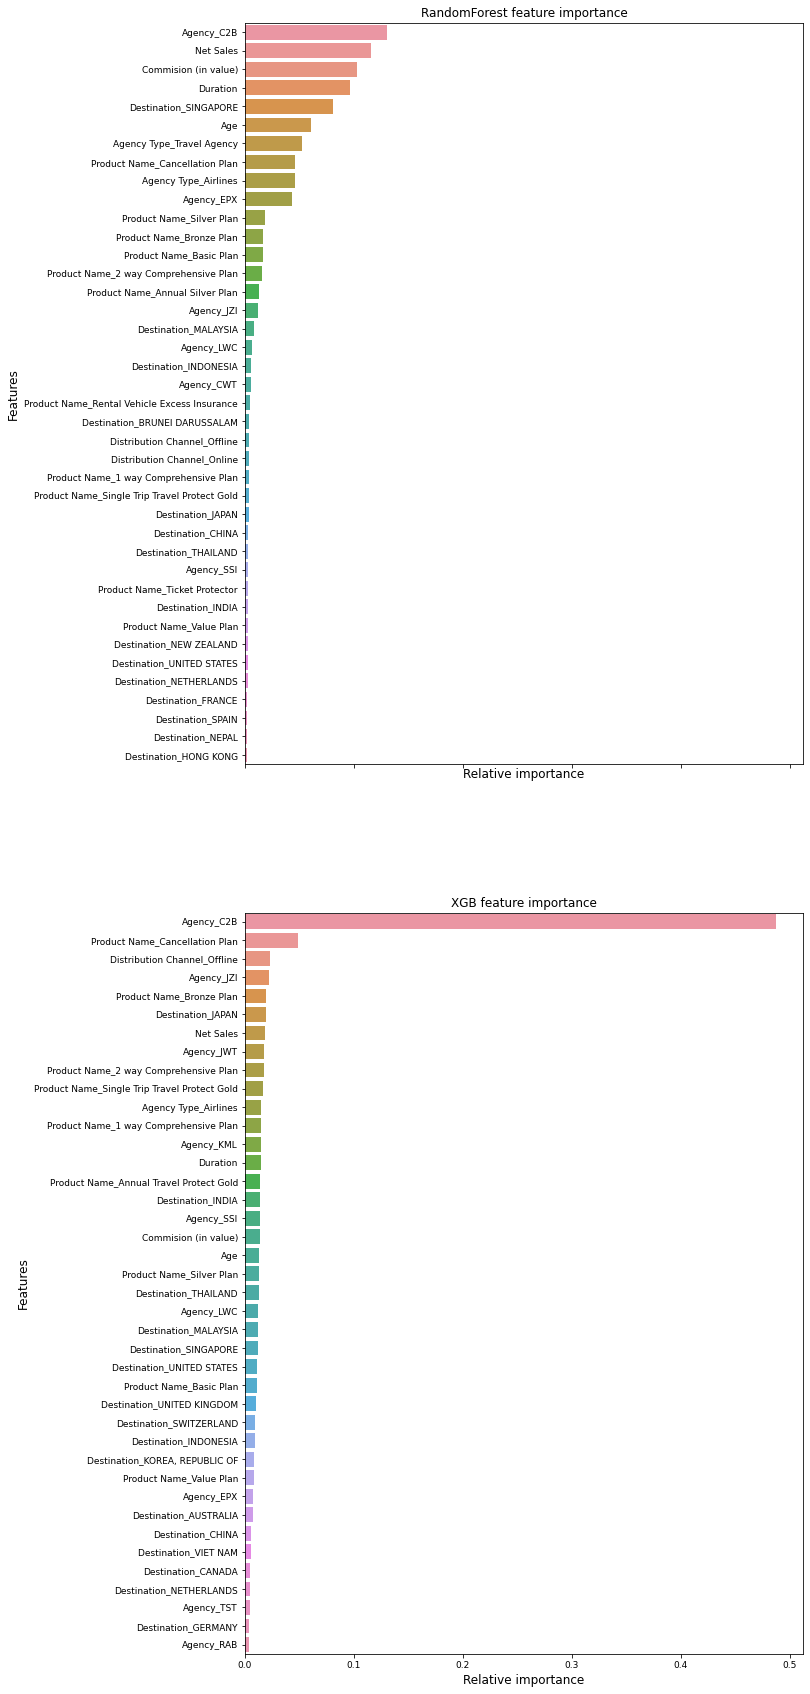

In [28]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex="all", figsize=(10, 30))

names_classifiers = [("RandomForest", trained_models["trained models/random_forest_7.pickle"][2]),
                    ("XGB", trained_models["trained models/xgb_4.pickle"][2])]

for row in range(0, len(names_classifiers)):
    name = names_classifiers[row][0]
    classifier = names_classifiers[row][1]
    indices = np.argsort(classifier.best_estimator_.feature_importances_)[::-1][:40]
    
    figure = sns.barplot(x = classifier.best_estimator_.feature_importances_[indices][:40],
                         y = X_train.columns[indices][:40],
                         orient='h', ax=axes[row])
    _ = figure.set_xlabel("Relative importance", fontsize=12)
    _ = figure.set_ylabel("Features", fontsize=12)
    _ = figure.tick_params(labelsize=9)
    _ = figure.set_title(name + " feature importance")

* Although the most important feature across XGBoost and Random Forest is 'Agency_C2B', the other top features are different.
* Hence it can be concluded that the models are using sufficiently different features and weights for prediction, which will help in creating a well performing ensemble.

### Checking the correlation between the classifier predictions

In [29]:
adaboost_results = trained_models['trained models/adaboost_5.pickle'][2].best_estimator_.predict(X_test)
xgb_results = trained_models['trained models/xgb_4.pickle'][2].best_estimator_.predict(X_test)
knn_results = trained_models['trained models/knn_4.pickle'][2].best_estimator_.predict(X_test)
rf_results = trained_models['trained models/random_forest_7.pickle'][2].best_estimator_.predict(X_test)
ridge_results = trained_models['trained models/ridge_4.pickle'][2].predict(X_test)

In [30]:
df_results = pd.DataFrame({'Ada': adaboost_results,
                           'XGB': xgb_results,
                           'KNN': knn_results,
                           'RF': rf_results,
                           'Ridge': ridge_results,
                           'y_true': y_test})

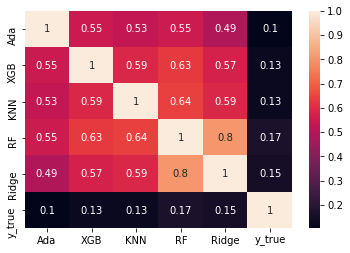

In [31]:
figure = sns.heatmap(df_results.corr(), annot=True)

* Random Forest and Ridge Classifier had a high correlation whereas other classifiers are moderately correlated.
* Creating a dataframe using the results of previous trained classifiers.

In [32]:
Xs, ys = df_results.drop(columns=['y_true'], axis=1, inplace=False), df_results['y_true'].copy()

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.3,
                                                       stratify=ys, random_state=42)

0.7885927267521415

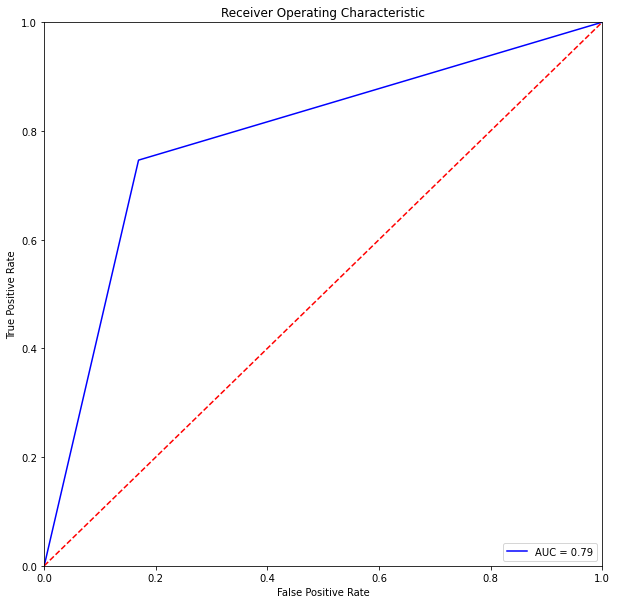

In [33]:
sample_weights = np.zeros(len(ys_train))
sample_weights[ys_train == 0] = 1
sample_weights[ys_train == 1] = 35

model = GradientBoostingClassifier(n_estimators=100, max_depth=3)

_ = model.fit(Xs_train, ys_train, sample_weight=sample_weights)

ys_pred = model.predict(Xs_test)

fpr, tpr, threshold = roc_curve(ys_test, ys_pred)
roc_auc = auc(fpr, tpr)
roc_auc

plot_auc(ys_test, ys_pred)

stack_model = model

### Business Impact

* For the Type 1 (False Positives) and Type 2 (False Negatives) Errors in the classifier may result in certain penalties in real life.
* If claims are approved when they shouldn't be (False Positives), the company loses money. 
    * This may or may not result in an increased customer satisfaction. More data is needed to test this hypothesis.
* If claims aren't approved when they should be (False Negatives), the company loses reputation.
    * This may or may not result in furthur loss of revenue due to bad word of mouth. Also, the company may generate more revenue by giving out less claims.
        * As before, more data is needed to test this hypothesis.


* Lastly, depending on the penalties in real world, the models can be trained by assigning certain weights to minimize the penalty through Type 1 and 2 errors.
* This will aid in creating a better classifier which will provide useful predictions.
* Due to absence of data to understand the penalties, both Type 1 and Type 2 errors are being assumed to have the same penalties.

### Making predictions on the holdout set

In [34]:
holdout = test.drop(columns=['Claim'], axis=1, inplace=False)
holdout.set_index('ID', inplace=True)

In [35]:
df_results = pd.DataFrame({'Ada res': trained_models['trained models/adaboost_5.pickle'][2].predict(holdout),
                           'XGB res': trained_models['trained models/xgb_4.pickle'][2].predict(holdout),
                           'KNN res': trained_models['trained models/knn_4.pickle'][2].predict(holdout),
                           'RF res': trained_models['trained models/random_forest_7.pickle'][2].predict(holdout),
                           'Ridge res': trained_models['trained models/ridge_4.pickle'][2].predict(holdout),
                          })

In [36]:
y_pred_final = stack_model.predict(df_results)
y_pred_final = pd.DataFrame({'Claim': y_pred_final}, index=holdout.index)
y_pred_final['Claim'] = y_pred_final['Claim'].astype(int)

In [37]:
y_pred_final

Claim
ID          
25902      0
19535      0
43717      0
48271      0
52318      0
...      ...
11166      0
47539      0
61110      0
33879      0
48914      0

[12661 rows x 1 columns]

In [38]:
y_pred_final.to_csv('final_prediction.csv')

----